In [1]:
%matplotlib inline
import numpy as np
import h5py as h5
import yt
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
yt.enable_plugins()

yt : [INFO     ] 2025-03-08 09:37:23,511 Loading plugins from /home/jwise/.config/yt/my_plugins.py


In [2]:
#dir_name = 'Split-IC-7rvir'
dir_name = '.'
num = 26813
dsname = 'output_0000'
#num = 1405450
fn = '%s/initial_particle_positions-%d-%s.h5' % (dir_name, num, dsname)
fp = h5.File(fn, 'r')
pos = fp['particle_position'][:]
pid = fp['particle_identifier'][:]
fp.close()

In [3]:
rmin = pos.min(0)
rmax = pos.max(0)
width = rmax - rmin
maxwidth = width.max()
center = 0.5 * (rmin + rmax)
ledge = center - 0.5*maxwidth
redge = center + 0.5*maxwidth
print(ledge, redge, center, width)

[0.48719203 0.39979125 0.41852383] [0.63436075 0.54695997 0.56569255] [0.56077639 0.47337561 0.49210819] [0.0871928  0.14716872 0.05667623]


In [4]:
factor = 3
com = pos.mean(axis=0)
pos_std = pos.std(axis=0)
radius = factor * pos_std
print(com)
print(radius)

[0.54643776 0.43513759 0.49048357]
[0.04398329 0.07266741 0.03921608]


In [5]:
pixels = 32

0.5171799884267118 0.6043727897786725
0.3997912459687725 0.5469599685117373
0.5464377590649656 0.4351375872063341
[[np.float64(0.48719202783120974), np.float64(0.6343607503741745)], [np.float64(0.3997912459687726), np.float64(0.5469599685117373)]]
(np.float64(0.5464377590649666), np.float64(0.4351375872063331)) [0.04398329 0.07266741 0.03921608]


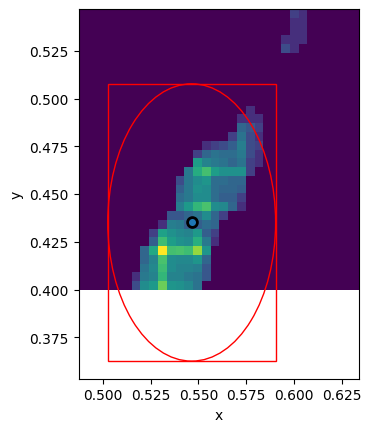

0.3997912459687725 0.5469599685117373
0.4637700711021451 0.5204463025814114
0.4351375872063341 0.4904835688421893
[[np.float64(0.3997912459687726), np.float64(0.5469599685117373)], [np.float64(0.4185238255702959), np.float64(0.5656925481132606)]]
(np.float64(0.4351375872063331), np.float64(0.4904835688421888)) [0.04398329 0.07266741 0.03921608]


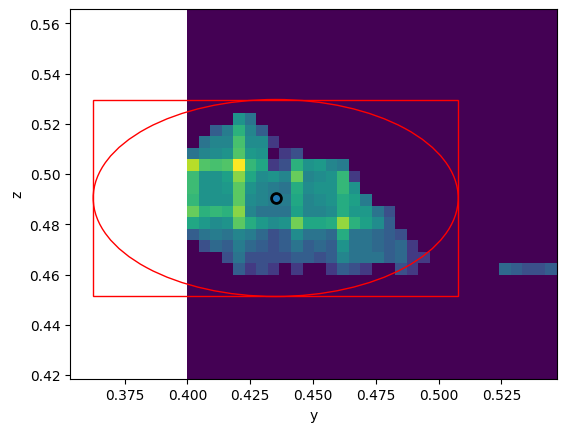

0.4637700711021451 0.5204463025814114
0.5171799884267118 0.6043727897786725
0.4904835688421893 0.5464377590649656
[[np.float64(0.4185238255702959), np.float64(0.5656925481132606)], [np.float64(0.48719202783120974), np.float64(0.6343607503741745)]]
(np.float64(0.4904835688421888), np.float64(0.5464377590649666)) [0.04398329 0.07266741 0.03921608]


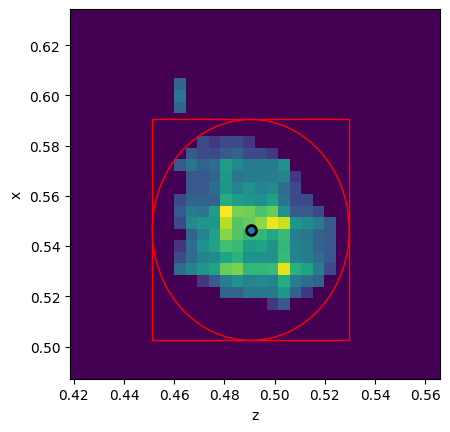

In [6]:
axes = ((0,1), (1,2), (2,0))
for axis in axes:
    extent = [[ledge[axis[0]], redge[axis[0]]], [ledge[axis[1]], redge[axis[1]]]]
    H, xedges, yedges = np.histogram2d(pos[:,axis[0]], pos[:,axis[1]], bins=pixels, range=extent)
    image = -1 * np.ones((pixels, pixels))
    nz = np.nonzero(H)
    fig, ax = plt.subplots(1,1)
    ax.imshow(np.sqrt(H.T), origin='lower', interpolation='nearest', extent=[extent[0][0], extent[0][1], extent[1][0], extent[1][1]])
    ax.scatter(com[axis[0]], com[axis[1]], marker='o', s=50, lw=2, edgecolor='k', c='C0')
    ax.set_xlabel('%c' % (axis[0]+120))
    ax.set_ylabel('%c' % (axis[1]+120))
    #circle = plt.Circle((com[axis[0]], com[axis[1]]), radius, color='r', fill=False)
    ellipse = Ellipse((com[axis[0]], com[axis[1]]), 2*radius[axis[0]], 2*radius[axis[1]], color='r', fill=False)
    rect = Rectangle((com[axis[0]]-radius[axis[0]], com[axis[1]]-radius[axis[1]]), 2*radius[axis[0]], 2*radius[axis[1]], color='r', fill=False)
    print(pos[:,axis[0]].min(), pos[:,axis[0]].max())
    print(pos[:,axis[1]].min(), pos[:,axis[1]].max())
    print(pos[:,axis[0]].mean(), pos[:,axis[1]].mean())
    print(extent)
    print((com[axis[0]], com[axis[1]]), radius)
    #ax.add_patch(circle)
    ax.add_patch(ellipse)
    ax.add_patch(rect)
    plt.show()

In [7]:
radius

array([0.04398329, 0.07266741, 0.03921608])

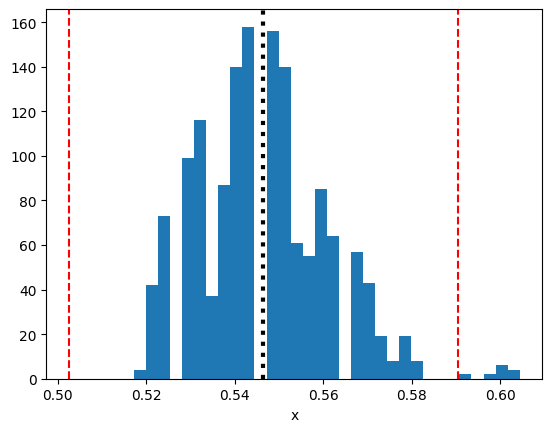

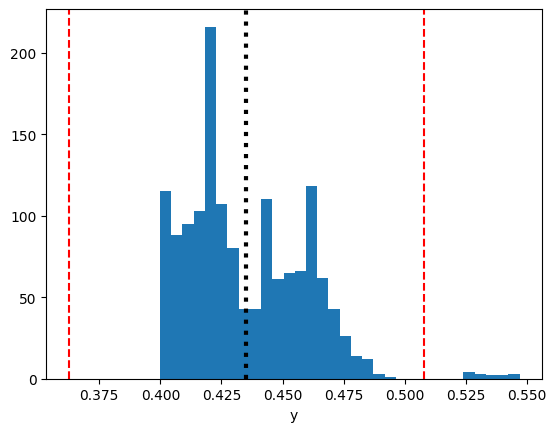

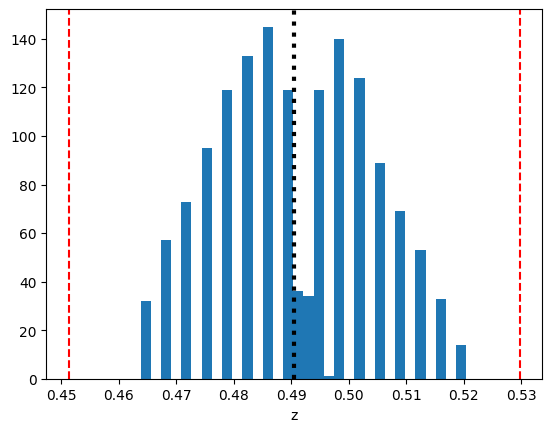

In [8]:
for i in range(3):
    plt.hist(pos[:,i], bins=pixels)
    plt.axvline(pos[:,i].mean(), lw=3, ls=':', c='k')
    plt.axvline(pos[:,i].mean()-radius[i], lw=1.5, ls='--', c='r')
    plt.axvline(pos[:,i].mean()+radius[i], lw=1.5, ls='--', c='r')
    plt.xlabel('%c' % (120+i))
    plt.show()

# Remove 3-sigma outliers

In [9]:
outliers = np.zeros(pos.shape[0], dtype='bool')
mean = pos.mean(0)
for dim in range(3):
    outliers |= (pos[:,dim] > mean[dim]+radius[dim]) | (pos[:,dim] < mean[dim]-radius[dim])

In [10]:
pos = pos[~outliers,:]
pos.shape

(1471, 3)

In [37]:
rmin = pos.min(0)
rmax = pos.max(0)
width = rmax - rmin
maxwidth = width.max()
center = 0.5 * (rmin + rmax)
radius = width/2
print(f'# Original width = {width}')
print(f'ParticleSplitterCenter         =  {center[0]:.9f} {center[1]:.9f} {center[2]:.9f}')
round_factor = 64  # ceil outer region to 1/round_factor
epsilon = 1e-3  # buffer between inner split region and width
ledge = center - 0.5*width - epsilon
redge = center + 0.5*width + epsilon
# Below assumes two splitting levels
for dim in range(3):
    print(f'ParticleSplitterCenterRegion[{dim}] = {np.ceil(width[dim]*round_factor)/round_factor:.6f} {width[dim]+epsilon:.6f}')
#ParticleSplitterCenterRegion[1] = 0.1 0.0947
#ParticleSplitterCenterRegion[2] = 0.06 0.0567


# Original width = [0.06477198 0.09461771 0.05667623]
ParticleSplitterCenter         =  0.549565980 0.447100099 0.492108187
ParticleSplitterCenterRegion[0] = 0.078125 0.065772
ParticleSplitterCenterRegion[1] = 0.109375 0.095618
ParticleSplitterCenterRegion[2] = 0.062500 0.057676


In [12]:
pixels = 32

0.5171799884267118 0.5819519709053259
0.3997912459687725 0.4944089515883654
0.5459276236379925 0.43419024907334347
[[np.float64(0.5022571268562224), np.float64(0.5968748324758153)], [np.float64(0.39979124596877247), np.float64(0.4944089515883654)]]
(np.float64(0.5464377590649666), np.float64(0.4351375872063331)) [0.03238599 0.04730885 0.02833812]


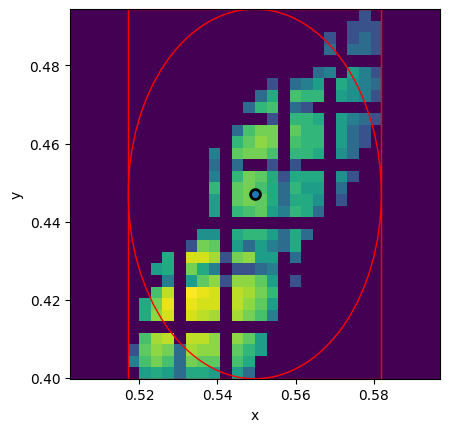

0.3997912459687725 0.4944089515883654
0.4637700711021451 0.5204463025814114
0.43419024907334347 0.4907351460726631
[[np.float64(0.39979124596877247), np.float64(0.4944089515883654)], [np.float64(0.4447993340319818), np.float64(0.5394170396515747)]]
(np.float64(0.4351375872063331), np.float64(0.4904835688421888)) [0.03238599 0.04730885 0.02833812]


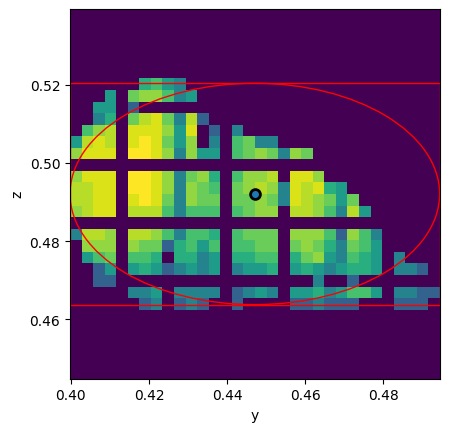

0.4637700711021451 0.5204463025814114
0.5171799884267118 0.5819519709053259
0.4907351460726631 0.5459276236379925
[[np.float64(0.4447993340319818), np.float64(0.5394170396515747)], [np.float64(0.5022571268562224), np.float64(0.5968748324758153)]]
(np.float64(0.4904835688421888), np.float64(0.5464377590649666)) [0.03238599 0.04730885 0.02833812]


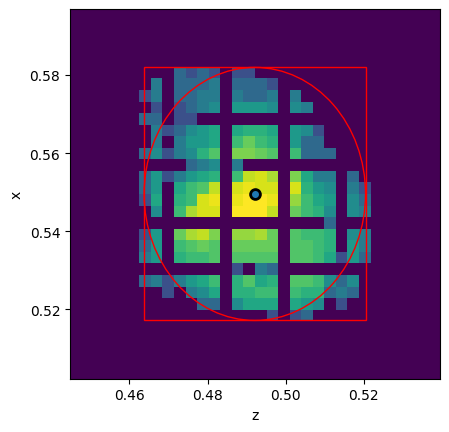

In [13]:
axes = ((0,1), (1,2), (2,0))
for axis in axes:
    extent = [[ledge[axis[0]], redge[axis[0]]], [ledge[axis[1]], redge[axis[1]]]]
    H, xedges, yedges = np.histogram2d(pos[:,axis[0]], pos[:,axis[1]], bins=pixels, range=extent)
    image = -1 * np.ones((pixels, pixels))
    nz = np.nonzero(H)
    fig, ax = plt.subplots(1,1)
    ax.imshow(np.sqrt(H.T), origin='lower', interpolation='nearest', extent=[extent[0][0], extent[0][1], extent[1][0], extent[1][1]])
    ax.scatter(center[axis[0]], center[axis[1]], marker='o', s=50, lw=2, edgecolor='k', c='C0')
    ax.set_xlabel('%c' % (axis[0]+120))
    ax.set_ylabel('%c' % (axis[1]+120))
    #circle = plt.Circle((com[axis[0]], com[axis[1]]), radius, color='r', fill=False)
    ellipse = Ellipse((center[axis[0]], center[axis[1]]), 2*radius[axis[0]], 2*radius[axis[1]], color='r', fill=False)
    rect = Rectangle((center[axis[0]]-radius[axis[0]], center[axis[1]]-radius[axis[1]]), 2*radius[axis[0]], 2*radius[axis[1]], color='r', fill=False)
    print(pos[:,axis[0]].min(), pos[:,axis[0]].max())
    print(pos[:,axis[1]].min(), pos[:,axis[1]].max())
    print(pos[:,axis[0]].mean(), pos[:,axis[1]].mean())
    print(extent)
    print((com[axis[0]], com[axis[1]]), radius)
    #ax.add_patch(circle)
    ax.add_patch(ellipse)
    ax.add_patch(rect)
    plt.show()

In [14]:
radius

array([0.03238599, 0.04730885, 0.02833812])

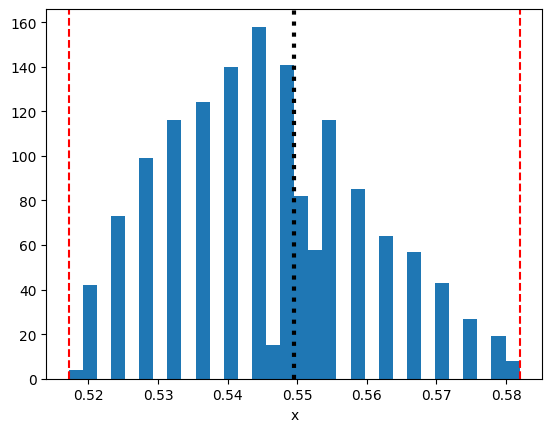

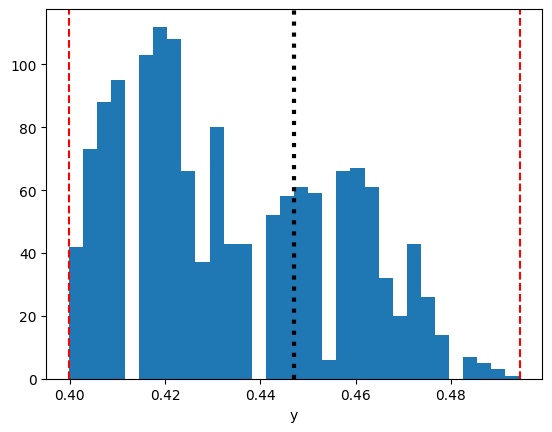

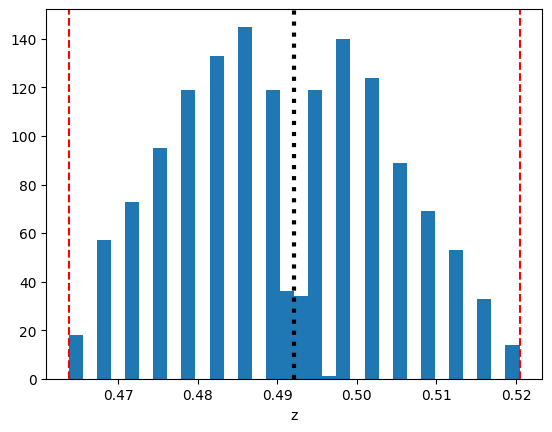

In [15]:
for i in range(3):
    plt.hist(pos[:,i], bins=pixels)
    plt.axvline(center[i], lw=3, ls=':', c='k')
    plt.axvline(center[i]-radius[i], lw=1.5, ls='--', c='r')
    plt.axvline(center[i]+radius[i], lw=1.5, ls='--', c='r')
    plt.xlabel('%c' % (120+i))
    plt.show()

# Write new HDF5 with outliers removed

The particle positions and IDs in the HDF5 aren't necessarily in the same order, i.e. pid[0] isn't the ID of the particle in position pos[0]. We have to search for the particle IDs of the outliers within the original dataset.

In [49]:
ds0 = yt.load('DD0000/output_0000')
reg = ds0.region(center, ledge, redge)
idx0 = reg['nbody', 'particle_index']
pos0 = reg['nbody', 'particle_position']
mask = np.isin(idx0, pid)

yt : [INFO     ] 2025-03-08 09:49:33,293 Parameters: current_time              = 0.81650998147377
yt : [INFO     ] 2025-03-08 09:49:33,294 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-03-08 09:49:33,294 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-08 09:49:33,295 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-03-08 09:49:33,295 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-03-08 09:49:33,296 Parameters: current_redshift          = 249
yt : [INFO     ] 2025-03-08 09:49:33,296 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2025-03-08 09:49:33,297 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2025-03-08 09:49:33,297 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-03-08 09:49:33,298 Parameters: hubble_constant           = 0.6766
Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████

In [50]:
new_fn = '.'.join(fn.split('.')[:-1]) + '-no-outliers.h5'
fp = h5.File(new_fn, 'w')
fp['particle_positions'] = pos0[mask]
fp['particle_identifier'] = idx0[mask].astype('int').v
fp.close()

# Troubleshooting

In [17]:
pos.max(0)

array([0.58195197, 0.49440895, 0.5204463 ])

In [18]:
pos.min(0)

array([0.51717999, 0.39979125, 0.46377007])

In [19]:
pid

array([616923, 623117, 623188, ..., 644568, 644640, 644858], shape=(1485,))

In [20]:
pid[~outliers]

array([623261, 623333, 623334, ..., 632837, 632838, 632982], shape=(1471,))

In [21]:
pid[outliers]

array([616923, 623117, 623188, 623189, 635499, 635717, 635789, 635858,
       635862, 636006, 644567, 644568, 644640, 644858])

In [22]:
pid[:20]

array([616923, 623117, 623188, 623189, 623261, 623333, 623334, 623406,
       623407, 626212, 626213, 626429, 626502, 626503, 626575, 626576,
       629380, 629453, 629524, 629526])

In [23]:
ds0 = yt.load('DD0000/output_0000')
ds0.add_particle_filter('mrp')
ad = ds0.all_data()

yt : [INFO     ] 2025-03-08 09:37:25,285 Parameters: current_time              = 0.81650998147377
yt : [INFO     ] 2025-03-08 09:37:25,286 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-03-08 09:37:25,286 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-08 09:37:25,287 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-03-08 09:37:25,287 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-03-08 09:37:25,287 Parameters: current_redshift          = 249
yt : [INFO     ] 2025-03-08 09:37:25,288 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2025-03-08 09:37:25,288 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2025-03-08 09:37:25,288 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-03-08 09:37:25,289 Parameters: hubble_constant           = 0.6766
Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████

In [24]:
idx0 = ad['nbody', 'particle_index']
pos0 = ad['nbody', 'particle_position']

In [25]:
np.isin?

Signature:      
np.isin(
    element,
    test_elements,
    assume_unique=False,
    invert=False,
    *,
    kind=None,
)
Call signature:  np.isin(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function isin at 0x7fd9001a4820>
File:            ~/.local/lib/python3.10/site-packages/numpy/lib/_arraysetops_impl.py
Docstring:      
Calculates ``element in test_elements``, broadcasting over `element` only.
Returns a boolean array of the same shape as `element` that is True
where an element of `element` is in `test_elements` and False otherwise.

Parameters
----------
element : array_like
    Input array.
test_elements : array_like
    The values against which to test each value of `element`.
    This argument is flattened if it is an array or array_like.
    See notes for behavior with non-array-like parameters.
assume_unique : bool, optional
    If True, the input arrays are both assumed to be unique, which
    can speed up the calculation.  Default is Fals

In [34]:
mask = np.isin(idx0, pid[~outliers])

In [35]:
mask.sum()

np.int64(1471)

In [36]:
pos0[mask].max(0)

unyt_array([0.60437279, 0.54695997, 0.5204463 ], 'code_length')